# APOE Dataset analysis

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.resolve()))

In [2]:
import pandas as pd
import numpy as np
from src.logreg_classifier import z_score, antilogit_classifier_score

## Note
- Classification based on APOE4
    - Average scores for subjects without APOE4
    - Subjects with 1 copy of APOE4
    - Subjects with 2 copies of APOE4.
- Subjects with APOE4 both are at increased risk (e.g. ~4-fold is one copy and ~12-fold if 2 copies) and have earlier onset of disease (e.g. ~5 yrs earlier for 1 and ~10 yrs earlier for 2 copies of APOE 4).

In [3]:
pathos = pd.read_excel("../../raw_data/Purdue expanded info AD subject sample added Info Apoe.xlsx")
raw_data = pd.read_excel(
    "../../raw_data/ClusterMarkers_1819ADcohort.congregated_DR.xlsx", sheet_name=1
)
# setting index row name to the gene id
raw_data = raw_data.set_index("gene_id")

In [4]:
pathos.head()

,Isolate ID,PatientID,Ethnicity,Gender,Disease,MMSE,CDR,Apoe status,Age
0,1817,434,NaN,Female,NCI,30.0,0.0,E3/E3,76.0
1,1818,435,NaN,Female,NCI,30.0,0.0,E2/E4,74.0
2,1821,438,NaN,Female,NCI,29.0,0.0,E3/E3,73.0
3,1850,447,NaN,Male,NCI,29.0,0.0,E3/E4,68.0
4,1854,451,NaN,Female,NCI,29.0,0.0,E3/E4,79.0


<Axes: xlabel='Apoe status'>

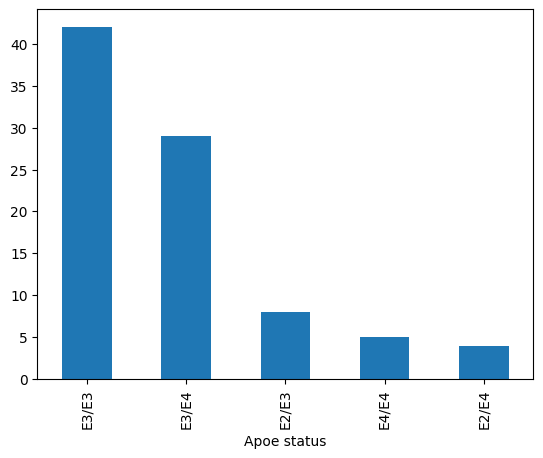

In [5]:
pathos["Apoe status"].value_counts().plot(kind="bar")

- Caucasian individuals have higher Alzheimers risk
- Asian + E4 - higher risk
- E4/E4 > E3/E4 > E2/E4 = E3/E3 > E2/E3
- Alzheimer's triad (well-supported in literature)
   - Age - older, more likely
   - Sex - women more likely
   - APOE status
   - ROC-AUC = 0.7 (if just triad used)
- Multimodal score (fusion of features)
- Integrate APOE and cfRNA status
    - What is the effect of incorporating APOE status on ROC AUC/ ROC curve?
- What group has no E4/ one copy of E4/ two copies of E4?
- What is the mean score of individuals in these categories?
- Dealing with missing APOE information
    - Discard
    - Impute with E3/E3
    - Infer the APOE status from primary sequencing information
- Mini Mental State Exam (MMSE)
  - cognitive tests for Alzheimer's disease
  - score sensitive to education level, memorization of test exams
  - test score is not the most reliable for Alzheimer's disease probability

In [6]:
pathos = pathos.set_index("Isolate ID")

<Axes: xlabel='MMSE'>

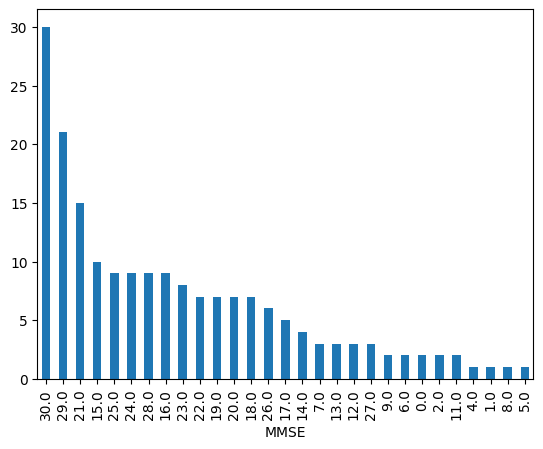

In [7]:
pathos["MMSE"].value_counts().plot(kind="bar")

In [8]:
patients_df = raw_data[~raw_data.loc[:, "Coeff"].isnull()]
coefficients = np.nan_to_num(np.array(patients_df.loc[:, "Coeff"]))
patients_df = patients_df.filter(regex="^\d+")

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_291260/443443847.py:3: SyntaxWarning: invalid escape sequence '\d'
  patients_df = patients_df.filter(regex="^\d+")


In [9]:
# group columns by patient id
grouped_cols = patients_df.columns.str.split("-").str[0]

# group columns by patient id and r1/r2 suffixes
grouped = patients_df.groupby(grouped_cols, axis=1)

# apply the mean function to the r1 and r2 columns for each group
# taking mean of the replicates for subjects with multiple replicates
patients_df = grouped.apply(lambda x: x.mean(axis=1)).reset_index(drop=True)
# Patients_df.head()

/tmp/ipykernel_291260/3094510434.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped = patients_df.groupby(grouped_cols, axis=1)


In [10]:
means, stds = patients_df.mean(axis=1), patients_df.iloc[:, :-1].std(axis=1)
z_scores_df = patients_df.iloc[:, :-2].apply(lambda x: z_score(x, means, stds))
z_scores_df.head()

,11174,11178,11182,11186,11190,11194,11198,11202,11206,11210,...,5664,5665,5666,5668,5669,5672,5673,5683,5702,5706
0,-0.162340,-0.124077,0.488874,-0.203704,0.140273,0.132526,-0.149614,-0.220407,-0.212424,1.734523,...,-0.540132,-0.551635,-0.574985,-0.307095,-0.575952,-0.549508,-0.481929,-0.152704,3.090238,-0.451351
1,-1.592178,-0.620937,-0.713870,-0.778313,-1.683587,-0.775737,-0.410247,0.366305,-0.058161,-0.184378,...,0.746434,1.629263,-0.424137,-0.561939,0.208487,0.204424,0.404535,-0.042250,-0.863545,0.296755
2,0.311638,-0.158153,0.136944,-0.391955,-0.429106,-0.163318,-0.368746,0.778421,0.897505,-0.089421,...,-0.084451,-0.164931,-0.521595,-0.493246,-0.424753,-0.320739,-0.331106,-0.263593,-0.388588,-0.229220
3,1.304496,-0.376202,0.194040,-0.422480,-0.450739,-0.181910,-0.350838,1.204130,1.709840,-0.105227,...,-0.204399,-0.084452,-0.455883,-0.532100,-0.196402,-0.237641,-0.422252,-0.500768,-0.598246,-0.051802
4,-0.295632,-0.471200,0.168103,-0.274287,-0.039378,0.275815,0.378081,0.547171,1.118234,-0.380994,...,0.060530,0.003058,0.602462,-0.681788,0.210895,-0.654845,-0.470758,-0.063767,-0.809409,0.014013


In [11]:
scores_apoe_df = pd.DataFrame([])
scores_apoe_df["scores"] = antilogit_classifier_score(z_scores_df.T @ coefficients)

In [12]:
scores_apoe_df.index = [int(val) for val in scores_apoe_df.index]

In [13]:
scores_apoe_df["Apoe status"] = pathos.loc[list(set(scores_apoe_df.index).intersection(set(pathos.index)))]["Apoe status"]

In [14]:
scores_apoe_df["Apoe status"].value_counts()

Apoe status
E3/E3    41
E3/E4    29
E2/E3     8
E4/E4     5
E2/E4     4
Name: count, dtype: int64